In [1]:
import time
from typing import Tuple
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision import models
from dataclasses import dataclass
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
@dataclass
class State:
    frame: torch.Tensor
    sp: float       # stamina points
    zoom: int

@dataclass
class Action:
    direction: int
    time_steps: int

# Check if frame has stone
def check_frame(self, frame) -> bool:
    crops = []
    for i in range(4):
        for j in range(4):
            crop = torchvision.transforms.functional.crop(frame, i * 24, j * 24, 24, 24)[None]
            crops.append(crop)
    expected_stone = self.stone_classifier(torch.cat(crops)).max(dim=0)[0][1].item()
    return expected_stone > 0.5

def find_state_with_stone(df: pd.DataFrame, max_attempt: int = 10) -> State:
    while True:
        index = np.random.randint(0, len(df) - 1)
        frame = load_image(df["video"][index], df["frame"][index])
        train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                               ToTensorV2(transpose_mask=False),
                               ])
        frame = train_aug(image=frame)['image']
        if env.check_frame(frame):
            break
    sp = df["sp"][index]
    zoom = df["zoom"][index]
    state = State(frame, sp, zoom)
    return state

def see_plot(pict, size=(6, 6), title: str = None):
    plt.figure(figsize=size)
    plt.imshow(pict, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]

In [3]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )


class ResNetUNet_v2(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)

        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])  # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1)  # (bath,10+1) --> (batch,512)

    def forward(self, inp):
        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(inp[0])
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2))  # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4 + cond)

        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)

        return out
#====================================================================    
    
class StoneClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 2, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 2, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 2, 1)
        self.fc1 = nn.Linear(32 * 3 * 3, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

## Env class

In [4]:
def apply_aug(p0, aug):
    if aug == 0:
        p = p0.copy()
    elif aug == 1:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
    elif aug == 2:
        p = cv2.rotate(p0, cv2.ROTATE_180)
    elif aug == 3:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif aug == 4:
        p = cv2.flip(p0, 1)
    elif aug == 5:
        p = cv2.rotate(p0, cv2.ROTATE_90_CLOCKWISE)
        p = cv2.flip(p, 1)
    elif aug == 6:
        p = cv2.rotate(p0, cv2.ROTATE_180)
        p = cv2.flip(p, 1)
    elif aug == 7:
        p = cv2.rotate(p0, cv2.ROTATE_90_COUNTERCLOCKWISE)
        p = cv2.flip(p, 1)
    return p

class NeuralEnv:
    def __init__(self,
                 env_model_path: str,
                 reward_model_path: str,
                 device: str,
                 batch_size = 16,
                 reward_confidence=0.5,
                 stone_frac=0.0,
                 step_size=4,
                 max_step=14):
        '''
        input params:
            env_model_path    [str] : path to model s_next=model(s_curr,action)
            reward_model_path [str] : path to model reward=model(s_curr)
            device            [str] : one of {'cpu', 'cuda:0', 'cuda:1'}
            batch_size        [int] : len of batch
            reward_confidence [flt] : classificator's confidence
            stone_frac        [flt] : part of the initial states with guaranteed stones
            step_size         [int] : 
            max_step          [int] : 
        output params:
            all output-variables will be torch.tensors in the selected DEVICE
            all input-variables have to be torch.tensors in the selected DEVICE
        '''
        self.device = device
        self.batch_size = batch_size
        self.reward_confidence = reward_confidence
        self.stone_frac = stone_frac
        self.step_size = step_size
        self.max_step = max_step
        self.reward_frame_transform = transforms.Compose([transforms.CenterCrop(24)])
        self.frame_transform = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                                          ToTensorV2(transpose_mask=False)])
        
        self.model = ResNetUNet_v2(3)
        self.model.load_state_dict(torch.load(env_model_path))
        self.model = self.model.to(self.device)
        self.model.eval()
        
        self.stone_classifier = StoneClassifier()
        self.stone_classifier.load_state_dict(torch.load(reward_model_path))
        self.stone_classifier = self.stone_classifier.to(self.device)
        self.stone_classifier.eval()

        self.df = pd.read_csv('/media/laggg/surviv_rl_data/dataset_inventory_v2.csv')
        self.df = self.df[self.df.zoom == 1].reset_index()
    #----------------------------------------------------------------------------------------------------
        
    def reset(self):
        '''
        output params:
            init_s     [float torch tensor [-1...1]] : batch of initial states (batch,3,96,96)
            init_supp  [float torch tensor]          : batch of initial support vector (batch,2)
        '''
        init_s = torch.zeros(self.batch_size,3,96,96).float()
        init_supp = torch.zeros(self.batch_size,2).float()
        
        for i in range(self.batch_size):
            j = np.random.randint(len(self.df))
            frame = load_image(self.df["video"][j], self.df["frame"][j])
            aug = np.random.choice(np.arange(8), p=np.array([0.125]*8))
            frame = apply_aug(frame, aug)
            frame = self.frame_transform(image=frame)['image']
            supp = torch.tensor([self.df["sp"][j]/100,self.df["zoom"][j]/15]).float()
            reward = self.get_reward(frame.unsqueeze(0).to(self.device))
            while reward>0:
                frame = frame.unsqueeze(0).expand(8,3,96,96).to(self.device)
                supp = supp.unsqueeze(0).expand(8,2).to(self.device)
                act = torch.tensor([x for x in range(8)]).to(self.device)
                frame, supp, reward = self.step(frame,supp,act)
                k = torch.argmin(reward)
                reward = reward[k]
                frame = frame[k].detach().cpu()
                supp = supp[k].detach().cpu()
            # +условие, чтобы агент c вер-тью p ресался на кадре, на котором где-то есть камень
            init_s[i] = frame
            init_supp[i] = supp
        return init_s.to(self.device),init_supp.to(self.device)
    #----------------------------------------------------------------------------------------------------
    
    def get_reward(self, state):
        '''
        input params:
            state [float torch.tensor [-1...1]] : batch of states (batch,3,96,96)
        output params:
            r      [float torch.tensor [0...1]]  : batch of rewards (batch,1)
        '''
        state = self.reward_frame_transform(state)
        with torch.no_grad():
            r = self.stone_classifier(state)[:,1].unsqueeze(1)
        r = (r>self.reward_confidence).float().detach()
        return r
    #----------------------------------------------------------------------------------------------------
    
    def step(self, s_curr, supp_curr, action):
        '''
        input params:
            s_curr    [float torch.tensor [-1...1]] : batch of current states (batch,3,96,96)
            supp_curr [float torch tensor]          : batch of current support vector (batch,2)
            action    [int torch tensor {0,...,7}]  : batch of chosen direction (batch,)  
        output params:
            s_next    [float torch.tensor [-1...1]] : batch of next states (batch,3,96,96)
            supp_next [float torch tensor]          : batch of next support vector =supp_curr (batch,2)
            reward    [float torch.tensor [0...1]]  : batch of rewards (batch,1)
        '''
        action_ohe = F.one_hot(action, num_classes=8).float() # (batch,8)
        if len(action)==1:
            action_ohe.unsqueeze(0)
        n =  torch.tensor([self.step_size/self.max_step]*action.size()[0])
        n = n.unsqueeze(1).float().to(self.device) # (batch,1)
        v = torch.cat([action_ohe,supp_curr,n], dim=1) # (batch,8+2+1)
        with torch.no_grad():
            s_next = self.model((s_curr,v)).detach()
        reward = self.get_reward(s_next)
        return s_next, supp_curr, reward

In [105]:
def inference_agent(model, s_init, supp_init):
    '''
    s_init (3,96,96) cuda
    supp_init (2,) cuda
    '''
    model.eval()
    s_curr = s_init.unsqueeze(0).clone()
    supp_curr = supp_init.unsqueeze(0).clone()
    
    for i in range(20):
        s_vis = (s_curr[0].permute(1,2,0).detach().cpu()+1)/2
        display.clear_output(wait=True)
        see_plot(s_vis)
        with torch.no_grad():
            act = torch.argmax(model(s_curr), dim=1)
        s_curr, supp_curr, reward = env.step(s_curr, supp_curr, act)
        time.sleep(0.1)

## Example

In [285]:
params = {'DEVICE': 'cuda:0',
          'BATCH': 128,
         'reward_confidence': 0.95}

# 0. build environment
env = NeuralEnv("./model_weights/resunet_v5.pth",
                "./model_weights/nostone_stone_classifier.pth",
                params['DEVICE'],
                params['BATCH'],
                params['reward_confidence'])

# 1. start session
s_curr,supp_curr = env.reset()
print('Init state:', s_curr.size(), supp_curr.size())

# 2. choose action with some algorithm
chosen_action = torch.tensor([0]*params['BATCH']).to(params['DEVICE']) # 0 = GO UP
print('Actions:', chosen_action.size())

# 3. get next state with enviroment
reward_curr = env.get_reward(s_curr)
s_next, supp_next, reward = env.step(s_curr, supp_curr, chosen_action)
print('Next state:', s_next.size(), supp_next.size(), reward.size(), reward_curr.size())

# если агент появился на камне то вывести:
for k in range(params['BATCH']):
    s0 = (s_curr[k].permute(1,2,0).detach().cpu()+1)/2
    s1 = (s_next[k].permute(1,2,0).detach().cpu()+1)/2
    r_curr = reward_curr[k].detach().cpu()
    r = reward[k].detach().cpu()
    if r_curr==1: # and r==1:
        print('Reward:', r)
        see_plot(torch.cat([s0,s1], dim=1), size=(8,4))

Init state: torch.Size([128, 3, 96, 96]) torch.Size([128, 2])
Actions: torch.Size([128])
Next state: torch.Size([128, 3, 96, 96]) torch.Size([128, 2]) torch.Size([128, 1]) torch.Size([128, 1])


## DQN model

In [20]:
class DQN_NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.vgg19(pretrained=True).features
        self.pool = nn.AdaptiveMaxPool2d((1,1), return_indices=False)
        self.head = nn.Sequential(nn.Conv2d(512, 32, kernel_size=(1, 1)),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout2d(0.1),
                                  nn.Conv2d(32, 8, kernel_size=(1, 1)),
                                  )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.head(x)   
        x = torch.flatten(x, 1)
        return x

In [22]:
r_ts = []
l_ts = []

def dqn_training(model, params):
    model.train()
    MSE = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=1e-4)
    env = NeuralEnv("./model_weights/resunet_v5.pth",
                    "./model_weights/nostone_stone_classifier.pth",
                    params['DEVICE'],
                    params['BATCH'],
                    0.95)
    n_attempts = 50
    n_steps = 105
    gamma = 0.7
    alpha = 0.7
    initial_epsilon = 0.2
    final_epsilon = 0.0001
    epsilon_decrements = np.linspace(initial_epsilon, final_epsilon,n_attempts*n_steps)

    for i in range(n_attempts):
        s_curr,supp_curr = env.reset()
        total_reward = 0
        total_loss = 0.0
        for j in range(n_steps):
            iteration = j + i*n_steps
            epsilon = epsilon_decrements[iteration]
            #print(iteration, epsilon)

            value_s_curr = model(s_curr)
            policy_action = torch.argmax(value_s_curr, dim=1) # (batch,)
            random_action = torch.randint(0,8,(params['BATCH'],)).to(params['DEVICE']) # (batch,)
            if random.random()<=epsilon:
                action = random_action
            else:
                action = policy_action
            s_next, supp_next, reward = env.step(s_curr, supp_curr, action)   
            value_s_next = model(s_next)
            y_pred = torch.sum(value_s_curr*F.one_hot(action, num_classes=8).float(), dim=1)
            y_gt = (1-alpha)*y_pred + alpha*(reward.squeeze()+gamma*torch.max(value_s_next, dim=1).values)
            y_gt = y_gt.clone().to(torch.float32).detach()

            opt.zero_grad()
            loss = MSE(y_pred, y_gt) 
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            opt.step()

            s_curr = s_next
            supp_curr = supp_next
            total_reward += reward.sum().item()
            total_loss += loss.item()
        
        r_ts.append(total_reward)
        l_ts.append(round(total_loss,4))
        if i % 10 == 0:
            print(i, total_reward, round(total_loss,4))

In [23]:
params = {'DEVICE': 'cuda:0',
          'BATCH': 32,
         'reward_confidence': 0.95}

q_model = DQN_NET().to(params['DEVICE'])
dqn_training(q_model, params)
torch.save(q_model.state_dict(), 'dqn_v1.pth')

0 21.0 0.4932
10 22.0 0.6168
20 30.0 0.4796
30 37.0 0.5035
40 52.0 0.6239


## Testing

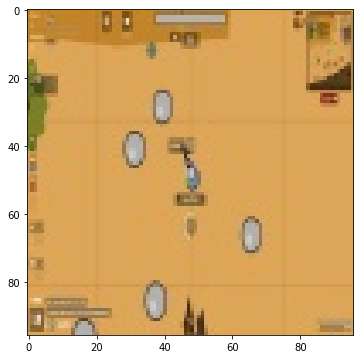

In [117]:
params = {'DEVICE': 'cuda:0',
          'BATCH': 1,
         'reward_confidence': 0.95}

env = NeuralEnv("./model_weights/resunet_v5.pth",
                "./model_weights/nostone_stone_classifier.pth",
                params['DEVICE'],
                params['BATCH'],
                params['reward_confidence'])

s_init,supp_init = env.reset()
s_curr = s_init[0]
supp_curr = supp_init[0]

see_plot((s_curr.permute(1,2,0).detach().cpu()+1)/2)

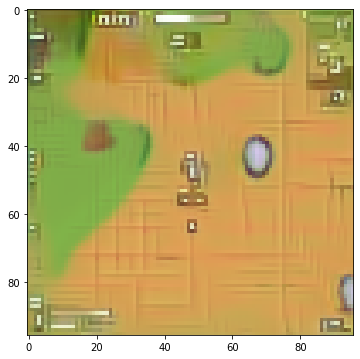

In [118]:
inference_agent(q_model, torch.rot90(s_curr, 0, [1,2]), supp_curr) 

In [52]:
def DQN_train():
    # s0,s1,a,r
    #s0 - (batch,3,96,96), (batch,2)
    #s1 - (batch,3,96,96), (batch,2)
    #a -  (batch,8)
    #r -  (batch,)
    
    output0 = model(s0)
    output = model(s1)
    
    y_pred = torch.sum(output0*a, dim=1)
    y_true = (1-alpha)*y_pred + alpha*(r+gamma*torch.max(output, dim=1).values)
    y_true = y_true.clone().to(torch.float32)
    y_true = y_true.detach()
    
    optimizer.zero_grad()
    loss = MSE(y_pred, y_true) 
    loss.backward()
    optimizer.step()